1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
#author: Federico Pilotto 2107076
#imports
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
nrows = 10000
path = 'data/data_000637.txt'

df = pd.read_csv(path, nrows=nrows)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11
9996,1,0,60,3869200267,701,5
9997,1,0,59,3869200267,707,23
9998,1,0,63,3869200267,706,15


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
max_bx = df['BX_COUNTER'].max()
print(max_bx)


3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [5]:
hours = df['ORBIT_CNT'] - df['ORBIT_CNT'].loc[0]
minutes = df['BX_COUNTER']*25
seconds = df['TDC_MEAS']


df_mean = df['BX_COUNTER'].mean()
df['Time'] = hours * df_mean * 25 + minutes + seconds

df['Time'] = df['Time'] - df['BX_COUNTER'].loc[0]*25 - df['TDC_MEAS'].loc[0]

df['Time'] = pd.to_datetime(df['Time'], unit='ns')

df = df.assign(Time = df['Time'])
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time
0,1,0,123,3869200167,2374,26,1970-01-01 00:00:00.000000000
1,1,0,124,3869200167,2374,27,1970-01-01 00:00:00.000000001
2,1,0,63,3869200167,2553,28,1970-01-01 00:00:00.000004477
3,1,0,64,3869200167,2558,19,1970-01-01 00:00:00.000004593
4,1,0,64,3869200167,2760,25,1970-01-01 00:00:00.000009649
...,...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11,1970-01-01 00:00:00.004487003
9996,1,0,60,3869200267,701,5,1970-01-01 00:00:00.004487122
9997,1,0,59,3869200267,707,23,1970-01-01 00:00:00.004487290
9998,1,0,63,3869200267,706,15,1970-01-01 00:00:00.004487257


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
df['Time'] = pd.to_datetime(df['Time']).dt.time
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,Time
0,1,0,123,3869200167,2374,26,00:00:00
1,1,0,124,3869200167,2374,27,00:00:00
2,1,0,63,3869200167,2553,28,00:00:00.000004
3,1,0,64,3869200167,2558,19,00:00:00.000004
4,1,0,64,3869200167,2760,25,00:00:00.000009
...,...,...,...,...,...,...,...
9995,1,0,61,3869200267,696,11,00:00:00.004487
9996,1,0,60,3869200267,701,5,00:00:00.004487
9997,1,0,59,3869200267,707,23,00:00:00.004487
9998,1,0,63,3869200267,706,15,00:00:00.004487


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
counts = df.groupby('TDC_CHANNEL')
print(counts.size().sort_values(ascending=False).head(3))

TDC_CHANNEL
139    860
63     499
64     491
dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [8]:
orbit_change = df["ORBIT_CNT"] - df["ORBIT_CNT"].shift(periods=-1)
print(orbit_change.loc[orbit_change >= 2])

n = abs(orbit_change.sum())
print(n)


Series([], Name: ORBIT_CNT, dtype: float64)
100.0


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
#Count number of different ORBIT_CNT on TDC_CHANNEL=139
k = df.loc[df['TDC_CHANNEL']==139].groupby(['ORBIT_CNT'])
print(len(k))

101


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
fpga0 = df.loc[df['FPGA'] == 0]
fpga1 = df.loc[df['FPGA'] == 1]

print(fpga0.groupby(df['TDC_CHANNEL']).size())
print(fpga1.groupby(df['TDC_CHANNEL']).size())


TDC_CHANNEL
1        4
2       10
3        8
4       11
5       11
      ... 
121     45
122     55
123    138
124    130
139    599
Length: 117, dtype: int64
TDC_CHANNEL
1      237
2      250
3      193
4      200
5      128
      ... 
125      2
126      1
127     10
128     11
139    261
Length: 115, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

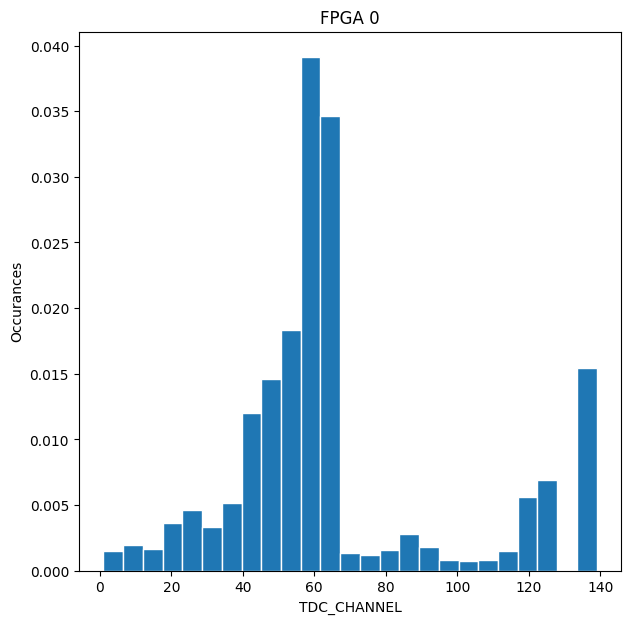

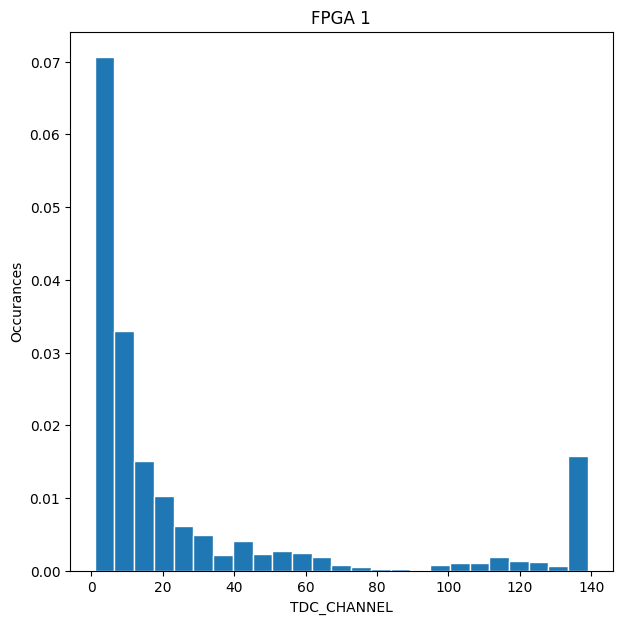

In [11]:
fig1 = plt.figure(num='Figure 1', figsize=(7, 7))
plt.hist(fpga0['TDC_CHANNEL'], bins=25, ec='white', density=True, cumulative=False)

#drawing the hist
plt.title('FPGA 0')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Occurances')
plt.show()

fig2 = plt.figure(num='Figure 2', figsize=(7, 7))
plt.hist(fpga1['TDC_CHANNEL'], bins=25, ec='white', density=True, cumulative=False)

#drawing the hist
plt.title('FPGA 1')
plt.xlabel('TDC_CHANNEL')
plt.ylabel('Occurances')
plt.show()